# Imports

In [1]:
import sys
sys.path.insert(1, '../')
from genesis import *

C:\Users\vin_s\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
universe = G10_FX
total_returns = total_returns_usd[universe]
spot_returns = spot_returns_usd[universe]
carry_returns = carry_returns_usd[universe]

# Settings

In [3]:
settings = Settings(start_date = "2000-01-01", end_date = "2016-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=126, rebalance_period="daily",
             sector_scaling_method="simple", sector_scaling_target=0.1, sector_scaling_width=126,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=252)

# Other Data

In [4]:
fwd = ['EUR1M CMPN Curncy', 'GBP1M CMPN Curncy', 'AUD1M CMPN Curncy', 
       'NZD1M CMPN Curncy', 'JPY1M CMPN Curncy', 'CAD1M CMPN Curncy', 
       'SEK1M CMPN Curncy', 'NOK1M CMPN Curncy', 'CHF1M CMPN Curncy']

fwd_scale_g10 = {"EURUSD": 10000,
                 "GBPUSD": 10000,
                 "AUDUSD": 10000,
                 "NZDUSD": 10000,
                 "USDJPY": 100,
                 "USDCAD": 10000,
                 "USDSEK": 10000,
                 "USDNOK": 10000,
                 "USDCHF": 10000}

fwd_data = new_raw_data[fwd].pipe(fill_date)#, fill_forward=True)
fwd_data.columns = fwd_scale_g10.keys()
for c in fwd_scale_g10.keys():
  fwd_data[c] = fwd_data[c]/fwd_scale_g10[c]
  
fwd_price_ori = spot_price_ori[fwd_scale_g10.keys()] + fwd_data

In [5]:
rx = fwd_price_ori.pipe(standardize_series, "prices").pipe(np.log10).shift(1) - \
     spot_price_ori[fwd_scale_g10.keys()].pipe(standardize_series, "prices").pipe(np.log10)

# Data integrity

In [6]:
rx.pipe(fill_date).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5635 entries, 2000-01-03 to 2021-08-06
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USDEUR  5634 non-null   float64
 1   USDGBP  5634 non-null   float64
 2   USDAUD  5634 non-null   float64
 3   USDNZD  5624 non-null   float64
 4   USDJPY  5634 non-null   float64
 5   USDCAD  5628 non-null   float64
 6   USDSEK  5631 non-null   float64
 7   USDNOK  5628 non-null   float64
 8   USDCHF  5630 non-null   float64
dtypes: float64(9)
memory usage: 440.2 KB


<AxesSubplot:>

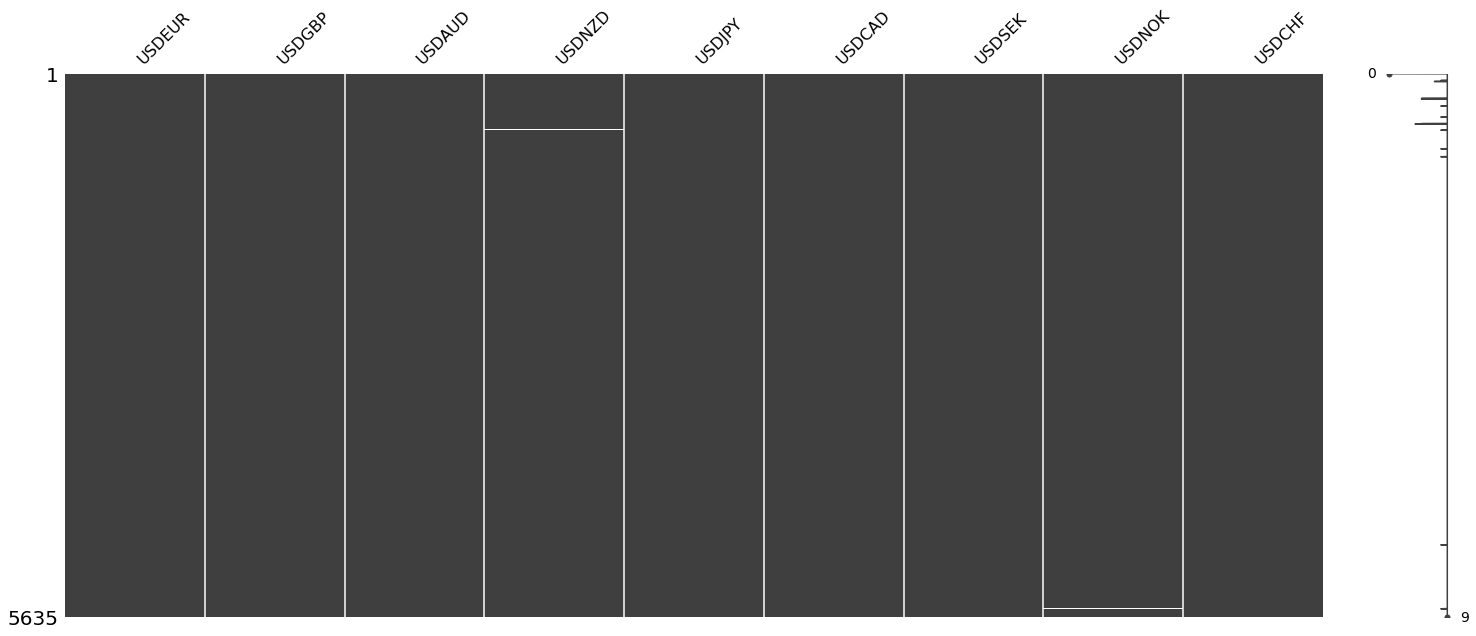

In [7]:
msmx(rx.pipe(fill_date))

# Signal

In [8]:
rx = rx.pipe(fill_date, True)

In [9]:
def rsv(x):
  mean = x.mean()
  rvu = sum([x**2 for x in x if x > mean])
  rvd = sum([x**2 for x in x if x <= mean])
  return rvd - rvu

In [10]:
rsv_signal = rx.groupby(rx.index.strftime('%Y-%m')).agg([rsv])
rsv_signal.columns = [x[0] for x in rsv_signal.columns]
rsv_signal.index = rx.loc[rx.groupby(rx.index.to_period('M')).apply(lambda x: x.index.max())].index

In [11]:
sig = rsv_signal.pipe(high_minus_low).pipe(fill_date, True)

# Backtest Daily Rebal

In [12]:
daily_bt = Backtest(signal = sig, asset_returns = total_returns, tcost = abs(total_returns*0), settings = settings)
daily_bt.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [13]:
get_summary(daily_bt)

Returns   : 0.05082396078330757
Vol       : 0.10224097707974339
SR        : 0.49709971710918954
Max DD    : -26.96

C Returns : 0.04664080188731319
C SR      : 0.413681433231759
C Max DD  : -24.25

Hit rate  : 0.523
W | N | L : 0.52 | 0.0 | 0.48
W/L Ratio : 1.1


In [14]:
get_returns_stats(daily_bt.asset_rtn, daily_bt.wts)

,USDAUD,USDCAD,USDEUR,USDGBP,USDJPY,USDNZD,USDSEK,USDNOK,USDCHF
annualized_return,1.248083,-0.764725,0.022508,0.628004,1.181311,2.028702,-0.020493,0.784563,-0.024366
sharpe,0.253474,-0.273019,0.008079,0.186698,0.226161,0.369175,-0.006233,0.211252,-0.005744
dollar_sharpe,0.220062,-0.289548,-0.006,0.177047,0.21294,0.29953,-0.023576,0.171032,-0.028392
trade_sharpe,0.352643,-0.489101,0.198068,0.236536,0.250104,0.37321,0.136576,0.330163,0.081835
long_sharpe,-0.570957,-0.431382,0.046411,0.251,0.300822,-0.934667,0.040235,0.34896,0.091479
short_sharpe,0.39013,-0.696192,1.179449,0.220375,-0.338,0.433261,0.56379,0.32251,-0.374216
sortino,0.140038,-0.096105,0.00254,0.066255,0.138891,0.23881,-0.002755,0.095541,-0.003055
max_drawdown,-12.101657,-19.054241,-16.167728,-9.394421,-20.099808,-16.030236,-12.369528,-21.966669,-16.012886
max_drawdown_start,2007-08-16,2002-04-01,2010-06-07,2009-12-29,2002-02-26,2014-07-09,2002-01-02,2003-05-29,2002-08-22
max_drawdown_end,2008-10-27,2015-03-17,2012-02-28,2011-07-29,2004-10-29,2015-10-01,2008-03-31,2014-11-18,2004-12-03


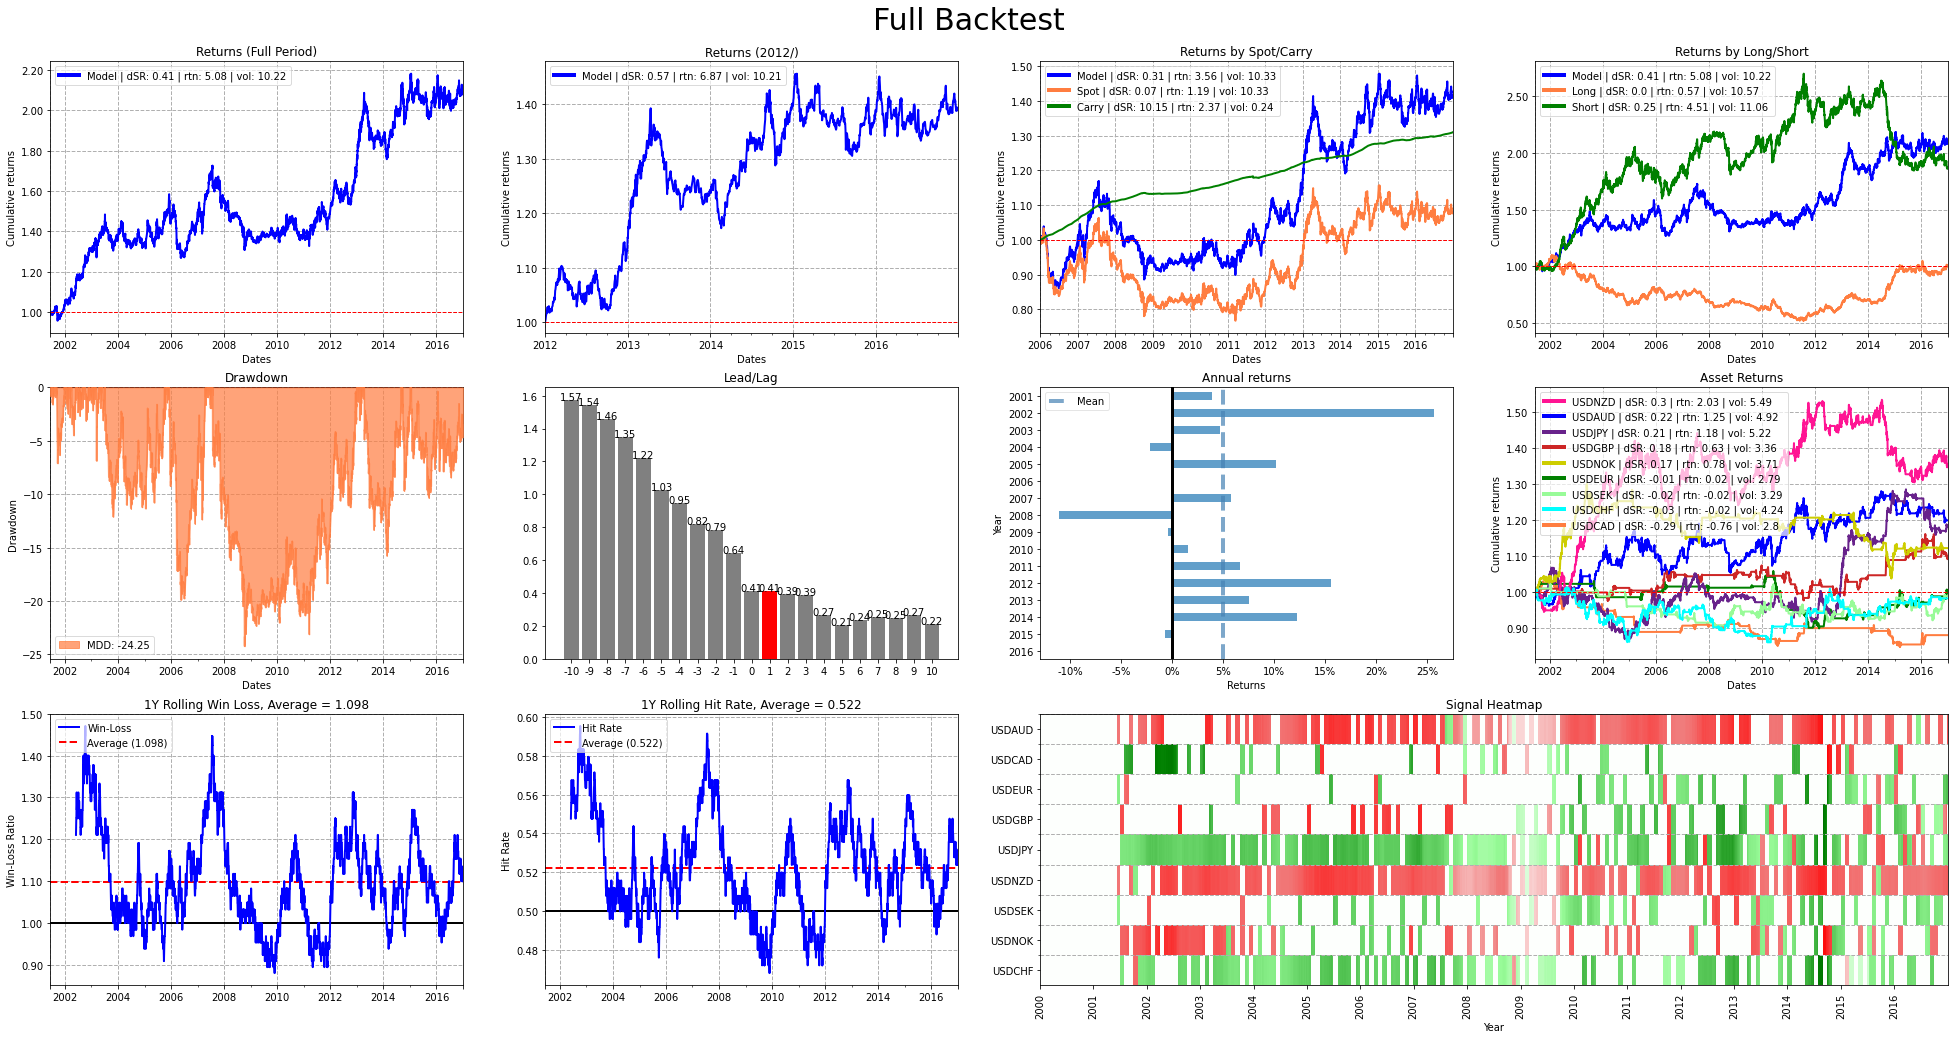

In [15]:
plot_bt(daily_bt)

In [16]:
# pickle.dump(daily_bt, open("../BT/rx_skew_g10.p", "wb"))
# daily_bt = pickle.load(open("../BT/rx_skew_g10.p", "rb"))

# Regime Plot

# Sensitivity Analysis

In [16]:
# pf.plot_monthly_returns_dist(bt_obj.model_rtn)